# Going beyond `pyodk`'s library methods

`pyodk` simplifies connecting to ODK Central using Python. 🐍

## Getting started
To get started with `pyodk`, you'll need to configure a Central server you'd like to connect to. Create a `.pyodk_config.toml` file in your home directory. Copy the following configuration and replace the placeholders:

```
[central]
base_url = "https://www.example.com"
username = "my_user"
password = "my_password"
default_project_id = 123
```

`pyodk` will use these credentials and defaults so that they never have to appear in your Python code.

You will then need to create a `Client` to establish a connection to your configured Central server:

In [26]:
from pyodk.client import Client

client = Client().open()

## Library methods

`pyodk` provides carefully-designed methods organized according to the resources they relate to. For example, you can get information about the default project:

In [27]:
client.projects.get()

Project(id=7, name='pyodk project', createdAt=datetime.datetime(2021, 2, 14, 23, 55, 48, 38000, tzinfo=datetime.timezone.utc), description="Examples for pyodk.", archived=None, keyId=None, appUsers=None, forms=None, lastSubmission=None, updatedAt=datetime.datetime(2022, 9, 20, 19, 21, 15, 241000, tzinfo=datetime.timezone.utc), deletedAt=None)

This returns a `Project` object with typed fields. Notice, for example, that `updatedAt` is a `datetime`.

## Raw HTTP requests

`podk` also provides methods on `client` to perform raw requests using the [`Requests` library](https://requests.readthedocs.io/en/latest/). This is useful if you're already comfortable with the ODK Central [API documentation](https://docs.getodk.org/central-api/) or you need functionality that isn't provided natively by `pyodk`.

For example, you can also get information about a project this way:

In [28]:
response = client.get("projects/7")
response.json()

{'id': 7,
 'name': 'pyodk project',
 'description': "Examples for pyodk.",
 'archived': None,
 'keyId': None,
 'createdAt': '2021-02-14T23:55:48.038Z',
 'updatedAt': '2022-09-20T19:21:15.241Z',
 'deletedAt': None}

The `get` request returned a [Response object](https://requests.readthedocs.io/en/latest/api/#requests.Response) and we got the response's JSON.

### Using the API docs

To write your own raw HTTP request, start by finding the endpoint that you would like to make a request to in [the documentation](https://docs.getodk.org/central-api/). For example, let's say you want to retrieve the XLSForm for a past form version. You can start by finding the API documentation [here](https://docs.getodk.org/central-api-form-management/#retrieving-form-version-xls-x). 

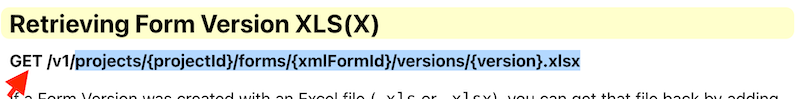

As shown by the arrow above, the `GET` method is specified so you will use the client’s `.get` method. You can start by pasting the desired endpoint path as a parameter:

```
r = client.get('/projects/{projectId}/forms/{xmlFormId}/versions/{version}.xlsx')
```

The parts of the URL that are in curly braces ({}) in the documentation are parameters that you need to set. For example, let’s say you want to access version `2012060401` of a form with the form ID `favorite_color` in project `7` on your server, you would fill in the placeholders like this:

In [29]:
response = client.get('/projects/7/forms/favorite_color/versions/2012060405.xlsx')
response.content[:150]

b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00|l\x98\x16i\x01\x00\x00\xa0\x05\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

In this case the response is binary data and it's not very useful as text. You could, for example, open it with [`openpyxl`](https://openpyxl.readthedocs.io/en/stable/) to edit it or you could save it to a local file:

In [25]:
if response.status_code == 200:
    with open('2012060405.xlsx', 'wb') as f:
        f.write(response.content)

The code above also shows checking the status code of the response before getting its contents.

### Requests that need input

If your request needs to specify some attributes, you can use request’s [json parameter](https://requests.readthedocs.io/en/latest/api/#requests.request). 

For example, let’s say you want to create a new App User with name “Lab Tech”. Start by reviewing the [API docs](https://docs.getodk.org/central-api-accounts-and-users/#creating-a-new-app-user). The `POST` method is specified so you will use your client’s `.post()` method. As above, you can copy the path and fill in values for the parameters:

```
response = client.post('/projects/7/app-users')
```

You also need to specify a value for the `displayName` attribute in your request:

In [39]:
r = client.post('/projects/7/app-users', json={'displayName': 'Lab Tech'})
r.json()

{'projectId': 7,
 'id': 684,
 'type': 'field_key',
 'displayName': 'Lab Tech',
 'createdAt': '2022-09-20T20:03:28.052Z',
 'updatedAt': None,
 'deletedAt': None,
 'token': 'IwstfMMYfeGwdebPH643OTmmzrPuSbmxBh9$W6u!g3PrI7wGTLbMsWGfvDWUzdDn',
 'csrf': '5NXWnOdUzA4JndSRiogXdfkiha0lOz8yDD4HQWgjplAciLYRnUccQfT$8oynK3cB',
 'expiresAt': '9999-12-31T23:59:59.000Z'}

The `r` variable now holds a [Response](https://requests.readthedocs.io/en/latest/api/#requests.Response) object representing the response to your request. If the request was successful, you can access the response json by calling `r.json()`. You can then do things like use the `id` or `token` in additional requests.


### Help us add the library methods you need!

Making raw HTTP requests can be a convenient way to quickly write up examples from the API documentation and to use uncommon endpoints. However, our goal with `pyodk` is to provide lots of useful functionality through carefully-designed library methods. If you find yourself reaching for raw HTTP methods a lot, please [file an issue](https://github.com/getodk/pyodk/issues) and let us know what functionality you'd like to see added to the library!